In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='paddyleafdiseaseuci (1) - Copy.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('paddyleafdiseaseuci (1) - Copy.zip')
f.keys()
!unzip "paddyleafdiseaseuci (1) - Copy.zip"

Archive:  paddyleafdiseaseuci (1) - Copy.zip
   creating: paddyleafdiseaseuci (1) - Copy/test/
   creating: paddyleafdiseaseuci (1) - Copy/test/Bacterial leaf blight/
  inflating: paddyleafdiseaseuci (1) - Copy/test/Bacterial leaf blight/blight-_0_1602.jpg  
  inflating: paddyleafdiseaseuci (1) - Copy/test/Bacterial leaf blight/blight-_0_1905.jpg  
  inflating: paddyleafdiseaseuci (1) - Copy/test/Bacterial leaf blight/blight-_0_1988.jpg  
  inflating: paddyleafdiseaseuci (1) - Copy/test/Bacterial leaf blight/blight-_0_2019.jpg  
  inflating: paddyleafdiseaseuci (1) - Copy/test/Bacterial leaf blight/blight-_0_2094.jpg  
  inflating: paddyleafdiseaseuci (1) - Copy/test/Bacterial leaf blight/blight-_0_2316.jpg  
  inflating: paddyleafdiseaseuci (1) - Copy/test/Bacterial leaf blight/blight-_0_2441.jpg  
  inflating: paddyleafdiseaseuci (1) - Copy/test/Bacterial leaf blight/blight-_0_2659.jpg  
  inflating: paddyleafdiseaseuci (1) - Copy/test/Bacterial leaf blight/blight-_0_2829.jpg  
  inf

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras

import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.12.0


In [ ]:
test_dataset = '/content/paddyleafdiseaseuci (1) - Copy/test'
train_dataset ="/content/paddyleafdiseaseuci (1) - Copy/train"
val_dataset ="/content/paddyleafdiseaseuci (1) - Copy/valid"

BATCH_SIZE = 20
IMG_SIZE = (224, 224)
no_classes = 3

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dataset,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 )
validation_dataset = tf.keras.utils.image_dataset_from_directory(val_dataset,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 )
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dataset,
                                                                 shuffle=True,
                                                               batch_size=BATCH_SIZE,
                                                               image_size=IMG_SIZE)

Found 911 files belonging to 3 classes.
Found 219 files belonging to 3 classes.
Found 164 files belonging to 3 classes.


In [ ]:
class_names = train_dataset.class_names

(20, 224, 224, 3)
[0 0 1 1 1 0 0 2 1 1 1 2 1 1 0 0 0 0 1 0]


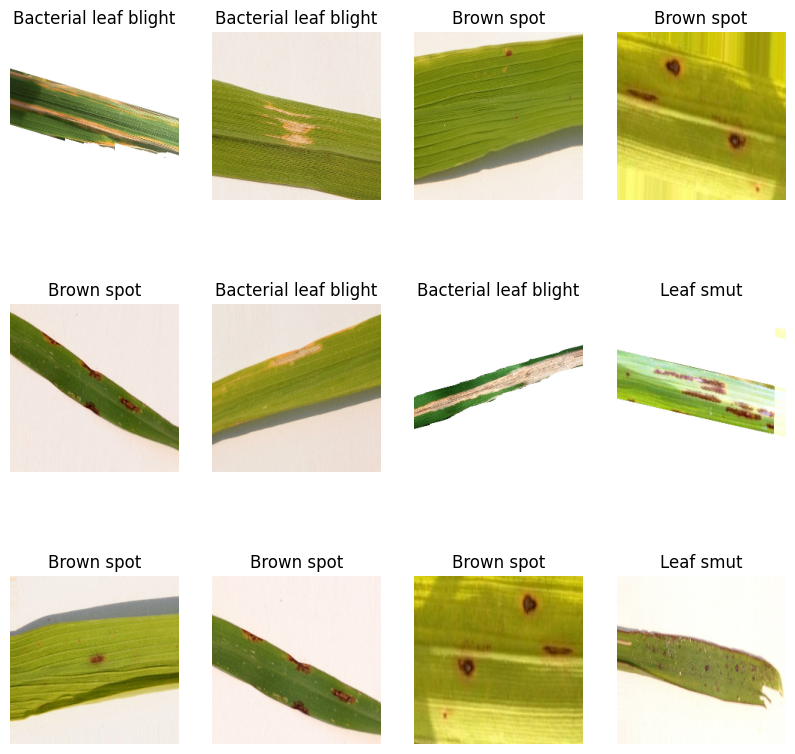

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in train_dataset.take(1):
  print (image_batch.shape)
  print (labels_batch.numpy())
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy ().astype( "uint8" ) )
    plt.title(class_names[labels_batch[i]])
    plt.axis( "off" )

In [ ]:
#from tensorflow.keras import models, layers
#import matplotlib.pyplot as plt


#resize_and_rescale = tf.keras.Sequential([
#    layers.experimental.preprocessing.Rescaling(1.0/255),
#    layers.experimental.preprocessing.Resizing (256,256)
#]
#)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential ([
    layers.experimental.preprocessing.RandomFlip( "horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(height_factor=(-0.2, -0.1)),

    layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.1, 0.1),
                                                        width_factor=(-0.1, 0.1))
]
)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_model = keras.applications.MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
nb_classes = 3
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D

x = base_model.layers[-2].output
x = data_augmentation(x)
x = Flatten()(x)

x = Dropout(0.5)(x)
x = keras.layers.Dense(512, activation="relu")(x)

output = Dense(nb_classes, activation="softmax")(x)
model_final = Model(inputs=base_model.input, outputs=output)



In [ ]:
model_final.compile(optimizer='adam' , loss='sparse_categorical_crossentropy',metrics =['accuracy'])

In [ ]:
epochs = 50
history = model_final.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)

Epoch 1/50
46/46 [==============================] - 59s 281ms/step - loss: 92.0474 - accuracy: 0.6290 - val_loss: 48.4420 - val_accuracy: 0.4475
Epoch 2/50
46/46 [==============================] - 9s 160ms/step - loss: 0.6478 - accuracy: 0.9495 - val_loss: 24.1346 - val_accuracy: 0.4612
Epoch 3/50
46/46 [==============================] - 10s 197ms/step - loss: 0.1661 - accuracy: 0.9660 - val_loss: 10.2535 - val_accuracy: 0.6027
Epoch 4/50
46/46 [==============================] - 12s 237ms/step - loss: 0.0844 - accuracy: 0.9726 - val_loss: 8.9406 - val_accuracy: 0.6758
Epoch 5/50
46/46 [==============================] - 9s 164ms/step - loss: 0.0277 - accuracy: 0.9923 - val_loss: 10.7110 - val_accuracy: 0.6530
Epoch 6/50
46/46 [==============================] - 10s 196ms/step - loss: 0.0647 - accuracy: 0.9879 - val_loss: 18.5729 - val_accuracy: 0.6484
Epoch 7/50
46/46 [==============================] - 9s 185ms/step - loss: 0.6490 - accuracy: 0.9265 - val_loss: 12.3157 - val_accuracy: 0.

In [ ]:
scores = model_final.evaluate(test_dataset)

In [ ]:
for images_batch, labels_batch in test_dataset.take(1):
  first_image = images_batch[0].numpy().astype("uint8")

  print("First image to predict")
  plt.imshow (first_image)
  print("Actua1 Label: ",class_names[labels_batch[0].numpy()])

  batch_prediction = model_final.predict(image_batch)
  print("Predicted Label: " ,class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model_final.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model_final, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
image_to_predict = [
    "/content/cochliobolus.jpg",
    "/content/5390515.jpg",
    "/content/bbb.png"
    ]

for imgi in image_to_predict:
  img = keras.utils.load_img(imgi, target_size=(224,224))
  ix = keras.utils.img_to_array(img)
  ix = np.expand_dims(ix, axis=0)
  prediction = model_final.predict(ix)
  cls = tf.argmax(prediction[0], axis=-1)
  print(prediction, cls)
  print(f'{class_names[cls]} --> {imgi}')

1/1 [==============================] - 0s 40ms/step
[[0.33179155 0.31123933 0.35696915]] tf.Tensor(2, shape=(), dtype=int64)
Leaf smut --> /content/cochliobolus.jpg
1/1 [==============================] - 0s 34ms/step
[[1.0000000e+00 4.8723098e-31 3.2438326e-27]] tf.Tensor(0, shape=(), dtype=int64)
Bacterial leaf blight --> /content/5390515.jpg
1/1 [==============================] - 0s 35ms/step
[[7.9249851e-09 2.5224786e-02 9.7477514e-01]] tf.Tensor(2, shape=(), dtype=int64)
Leaf smut --> /content/bbb.png
